# TreeView Simulations

In [1]:
import xarray
import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
import numpy as np
import os
import pandas as pd
import json
import seaborn
import yaml
import copy

from pyeosim.atmosphere import LUT_from_file
from pyeosim.datasets import DATA_PATHS
from pyeosim.spectral import TreeView_1, TreeView_2, Sentinel2VNIR, SuperDove, TreeView_3
from pyeosim.sensor import TCMOS_test, TeledyneCMOS
from pyeosim.plot import rgb

# PLOTTING COLORMAPS
cmap1=['blue', 'darkturquoise', 'limegreen', 'darkgreen', 'orange', 'deeppink', 'red','brown','grey', 'k']
cmap2=['blue', 'limegreen', 'darkgreen', 'orange', 'red','brown','grey', 'k']
cmap_mako = copy.copy(matplotlib.cm.get_cmap('mako'))
cmap_mako.set_bad(color='k')

# PARAMETERS
REFLECTANCE_DATASET = DATA_PATHS['TEST_HSI_LARGE']
ATMOSPHERE_PATH = os.path.join('atmospheres', 'atmospheres_2')
spectral_response = TreeView_3()

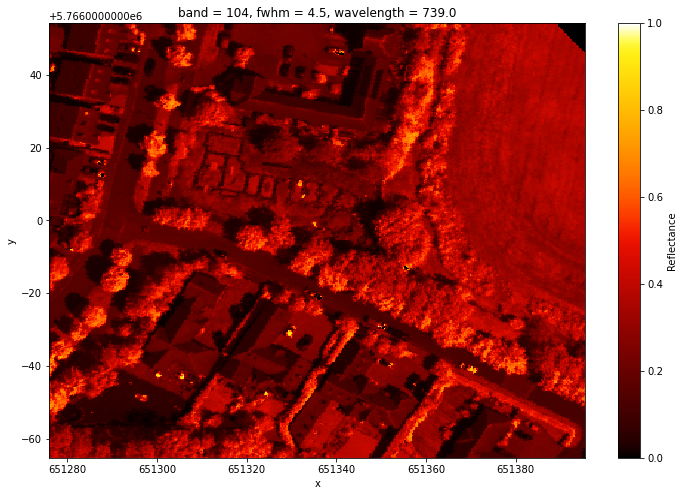

In [2]:
# This data is bottom of atmosphere reflectance (approximated) and so is used as starting point for simulation
surface_reflectance = xarray.open_dataset(REFLECTANCE_DATASET).Reflectance
surface_reflectance = surface_reflectance.swap_dims({'band':'wavelength'})
# slice between 400 and 898 to reduce data volume and align with the bandpass responses used later in simulation
# Also rescale to reflectance by divide by 10000
surface_reflectance = surface_reflectance.sel(wavelength=slice(400,898)).astype(float)/10000
# replace anything with a greater than 1 reflectance by truncating at 1
surface_reflectance = surface_reflectance.where(surface_reflectance <= 1, other=1)
surface_reflectance.sel(wavelength=740,
                        method='nearest').plot(robust=False,
                                               size=8,
                                               cmap=cc.cm.fire)

## 2. Convert to Radiance
This stage converts Surface Reflectance to Top-Of-Atmosphere Radiance using a precomputed atmospheric lookup table. Note that there are a range of different UK scenarios in the dataset. The parameters are detailed in the table below:

In [3]:
def read_atmos_meta(path):
    """
    Loads JSON file containing atmospheric simulation parameters used in 6SV
    """
    jsons = os.listdir(path)
    jsons = [x for x in os.listdir(path) if x.endswith('json')]
    metas = {}
    for _json in jsons:
        with open(os.path.join(path, _json), 'r') as f:
            metas[_json.split('.')[0]] = json.load(f)
    return pd.DataFrame(metas).T

atmos_meta = read_atmos_meta(ATMOSPHERE_PATH)
atmos_meta

,version,month,day,solar_z,solar_a,view_z,view_a,scattering_angle,azimuthal_angle_difference,visibility,...,atmospheric_intrinsic_reflectance,background_reflectance,pixel_reflectance,direct_solar_irradiance,diffuse_solar_irradiance,environmental_irradiance,atmospheric_intrinsic_radiance,background_radiance,pixel_radiance,solar_spectrum
inv_20200622_1030_nadir,1.1,6,22,36,150,0,0,143.36,150.3,8.49,...,0.089,0.384,0.537,639.951,601.212,306.191,41.59,180.168,252.17,1836.922
inv_20200622_1200_nadir,1.1,6,22,34,186,0,0,145.86,186.04,8.49,...,0.091,0.387,0.541,677.159,611.508,317.91,44.036,187.063,261.821,1836.922
inv_20200301_1030_nadir,1.1,3,1,67,156,0,0,112.95,156.93,8.49,...,0.125,0.309,0.432,135.397,374.7,125.839,29.904,74.046,103.638,1933.95
inv_20201001_1030_nadir,1.1,10,1,62,162,0,0,117.81,162.28,8.49,...,0.112,0.33,0.461,210.29,427.994,157.463,31.415,92.654,129.682,1892.893
inv_20200801_1030_nadir,1.1,8,1,42,151,0,0,137.72,151.28,8.49,...,0.088,0.377,0.528,551.236,575.304,277.914,38.208,163.529,228.882,1841.392
inv_20200501_1030_nadir,1.1,5,1,44,155,0,0,135.81,155.35,8.49,...,0.088,0.374,0.524,527.183,573.474,271.529,37.746,159.772,223.623,1870.334
mk_20200622_1030_nadir,1.1,6,22,33,140,0,0,146.71,140.71,8.49,...,0.091,0.387,0.542,689.322,614.763,321.714,44.657,189.301,264.954,1836.922
mk_20200622_1200_nadir,1.1,6,22,28,180,0,0,151.4,180.45,8.49,...,0.092,0.391,0.547,752.294,630.802,341.206,47.228,200.771,281.007,1836.922
mk_20200301_1030_nadir,1.1,3,1,63,152,0,0,116.99,152.18,8.49,...,0.113,0.326,0.457,200.697,427.417,154.954,31.679,91.177,127.615,1933.95
mk_20201001_1030_nadir,1.1,10,1,57,157,0,0,122.21,157.28,8.49,...,0.103,0.345,0.482,287.355,474.943,188.056,33.019,110.655,154.878,1892.893


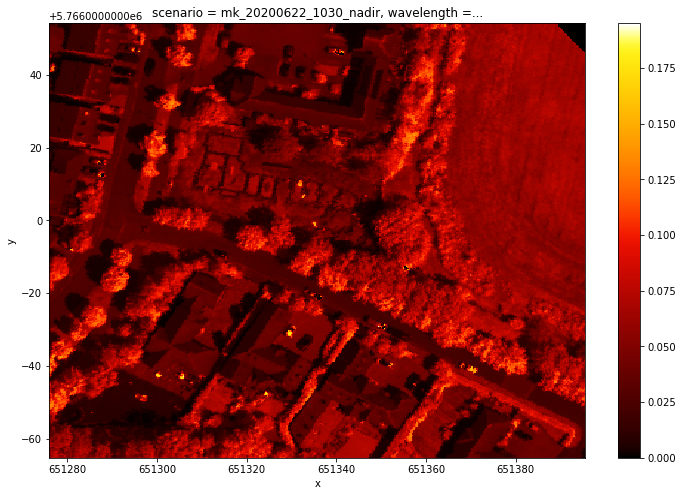

In [4]:
atmos = LUT_from_file(ATMOSPHERE_PATH, {
    'view_z': 0,
    'view_a': 0
})
# # generate Top of Atmosphere radiance array
radiance = atmos.transform(surface_reflectance).compute()
radiance.isel(scenario=6).sel(wavelength=740,
                              method='nearest').plot(robust=False,
                                                     size=8,
                                                     cmap=cc.cm.fire)

## 3. Estimate Range of Radiances at Sensor
Using the range of scenarios, representing extremes of UK imaging scenarios, we can estimate the range of likely radiances for each sensor band. To do this, we convolve the radiance spectrum with the spectral response function of the band.

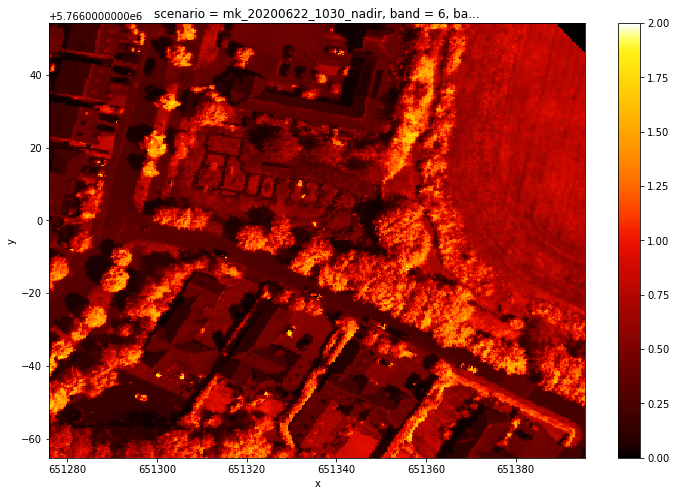

In [5]:
convolved_radiance = spectral_response.transform(radiance)
convolved_radiance.isel(scenario=6, band=6).plot(size=8,
                                                 cmap=cc.cm.fire)

In [6]:
def to_quantiles(arr, quantiles = [.025, .5, .975]):
    out = {}
    for q in quantiles:
        out['q{}'.format(q*100)] = arr.quantile(q,['x','y','scenario']).to_pandas().T
    try:
        out['band_name'] = arr.band_name
    except AttributeError:
        out['wavelength'] = arr.wavelength
    return pd.DataFrame(out)

# Generate radiance 95% range for all pixels in scene
radiance_95_whole_scene = to_quantiles(convolved_radiance)
radiance_95_whole_scene

,q2.5,q50.0,q97.5,band_name
band,,,,
0,0.007994,0.052488,0.245101,Aerosol
1,0.039365,0.372618,1.294600,PRI_1
2,0.050259,0.554705,2.043403,PRI_2
3,0.034935,0.394930,1.761027,Chlorophyll_1
4,0.029918,0.341115,1.782892,Chlorophyll_2
5,0.028710,0.399791,1.184459,RedEdge_2
6,0.028319,0.368623,1.192397,RedEdge_3
7,0.056413,0.685307,2.138841,NIR


As well as calculating radiance range estimates for the whole scene, we also need estimates for only vegetated areas. To do this, we can mask with NDVI values above a threshold of 0.2

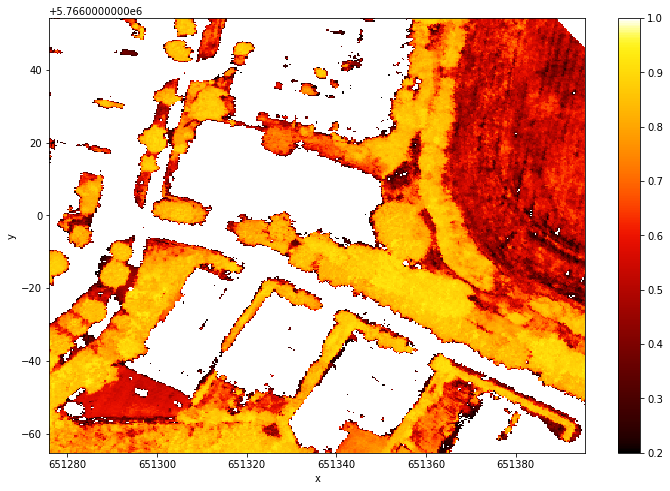

In [7]:
def to_treeview_ndvi(arr):
    IR = arr.sel(band=7)
    R = arr.sel(band=4)
    return (IR - R) / (IR + R)

# Do the same thing but for surface reflectance to estimate TreeView NDVI
convolved_surface_reflectance = spectral_response.transform(surface_reflectance)
treeview_ndvi = to_treeview_ndvi(convolved_surface_reflectance)
veg_mask = treeview_ndvi > 0.2
treeview_ndvi.where(veg_mask).plot(size=8,
                                             cmap=cc.cm.fire)

In [8]:
# Generate radiance 95% range for all pixels in scene
radiance_95_veg = to_quantiles(convolved_radiance.where(veg_mask))
radiance_95_veg

,q2.5,q50.0,q97.5,band_name
band,,,,
0,0.006794,0.035079,0.092799,Aerosol
1,0.034360,0.301889,0.680186,PRI_1
2,0.043595,0.430607,1.008760,PRI_2
3,0.029498,0.272287,0.759201,Chlorophyll_1
4,0.025286,0.209673,0.698071,Chlorophyll_2
5,0.038629,0.575796,1.277482,RedEdge_2
6,0.041537,0.571605,1.282571,RedEdge_3
7,0.088418,1.056306,2.295523,NIR


## 4. Plotting Sensor properties
This section just deals with plotting

Text(0.5, 1.0, 'TreeView')

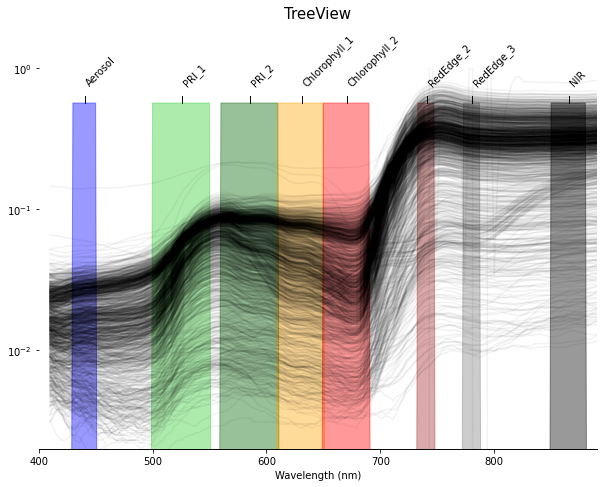

In [9]:
ymax = .7
f, ax = plt.subplots(figsize=(10,7))

for n, c in zip(spectral_response.band_names,
                cmap2):
#     srf.srfs[n].plot(c=c, label=n,)
    ax.fill_between(x=spectral_response.srfs[n].wavelength,
                    y1=spectral_response.srfs[n].values*ymax,
                    color=c,
                    alpha=.4)

ax.set_ylim(.003,ymax*1.1)
ax.set_xlim(400,890)
# plt.legend()

ax.set_yticks([])
ax.set_ylabel('')

for wlen, name in zip(spectral_response.band_wavelengths.values(),
                      spectral_response.band_names):
    ax.annotate(name, (wlen,ymax*1.05), rotation=45)
    ax.annotate('I', (wlen,ymax*1), rotation=0)

# Separate axis for vegetation spectra
ax2 = ax.twinx()
surface_reflectance.where(treeview_ndvi>.2).stack({'pix':['x','y']}).dropna('pix')[:, ::58].plot.line(x='wavelength',
                                                                             add_legend=False,
                                                                            color='k', alpha=.05)
ax2.set_ylabel('')
ax2.set_yscale('log')
ax2.yaxis.tick_left()
ax2.set_ylim(.002,1)
ax2.set_xlim(400,890)

# remove additional ticklines
ticks = ax2.yaxis.get_minor_ticks()
[x.set_visible(False) for x in ticks]

seaborn.despine(left=True)
ax.set_xlabel('Wavelength (nm)')
plt.title('TreeView', size=15, loc='center',pad=50)

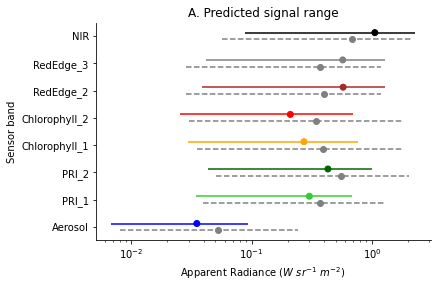

In [10]:
def radiance_range_plot(ax=None):
    if ax is None:
        _, ax = plt.subplots()
        # plot whole scene values
    ax.hlines(np.arange(0,16,2),
               radiance_95_whole_scene['q2.5'],
               radiance_95_whole_scene['q97.5'],
               edgecolor='gray', linestyle='--', label='all')
    ax.scatter(radiance_95_whole_scene['q50.0'],
                np.arange(0,16,2),
                c='gray')
    # plot vegetation scene values
    ax.hlines(np.arange(.5, 16.5, 2),
               radiance_95_veg['q2.5'],
               radiance_95_veg['q97.5'],
               edgecolor=cmap2,
               label='vegetation')

    ax.scatter(radiance_95_veg['q50.0'],np.arange(0.5,16.5,2), c=cmap2)
    ax.set_yticks(np.arange(.25, 16.25, 2))
    ax.set_yticklabels(radiance_95_veg.band_name)
    ax.set_xlabel(r'Apparent Radiance ($W~sr^{-1}~m^{-2}$)')
    ax.set_ylabel('Sensor band')
    ax.set_title('A. Predicted signal range')
    ax.set_xscale('log')

radiance_range_plot()
seaborn.despine()

## 5. Sensor SNR by Simulation
Simulator can be used to generate the SNR curves for a range of radiance values. In this case, we will calculate the per-band (hi-resolution data) 95% quantile and use this for each SNR band.

In [11]:
def generate_treeview_snr_curves(sensor_configuration,
                                 radiance_range_dataframe,
                                 n_steps=100,
                                 n_repeats=10000,
                                 n_bins=1):
    """
    Generates per-band Signal-to-Noise ratio curves for a radiance range.
    
    Parameters
    ----------
    sensor_configuration : dict
        All parameters needed to configure the TeledyneCMOS class
    radiance_range_dataframe : pd.DataFrame
        radiance range dataframe with wavelength, q2.5 and q97.5 fieds
    n_steps : int
        number of radiance levels to simulate between min and max
    n_repeats : int
        The number of repeat observations to construct the histogram
    bins : int
        The number of pixels to bin together to simulate on-chip binning
        
    """
    sensor = TCMOS_test(**sensor_configuration)
    # define vals from dataframe
    radiance_wavelengths = radiance_range_dataframe['wavelength']
    min_radiance = radiance_range_dataframe['q2.5']
    max_radiance = radiance_range_dataframe['q97.5']
    # Generate simulation array
    bindex = np.arange(len(radiance_wavelengths))
    radiance_tvals = np.zeros((len(bindex), n_steps))
    
    for _min, _max, i in zip(min_radiance, max_radiance, bindex):
        radiance_tvals[i, :] = np.linspace(_min, _max, n_steps)
    rad_tvals = xarray.DataArray(np.repeat(radiance_tvals[..., np.newaxis], n_repeats, axis=2),
                                      coords=[('wavelength', radiance_wavelengths),
                                              ('x', np.arange(n_steps)),
                                              ('y', np.arange(n_repeats))])
    # Run Simulation
    s1_snr = sensor.fit_transform(rad_tvals)
    # Truncate arrays at ADC max
    s1_snr = s1_snr.where(s1_snr < (2**12)-1)
    # Do binning
    if n_bins > 1:
        s1_snr = s1_snr.groupby(xarray.DataArray(np.tile(np.arange(n_repeats//n_bins), n_bins), dims=['y'])).sum()
        return (s1_snr.mean('group', skipna=False)/s1_snr.std('group', skipna=False)).fillna(-1)
    # calculate SNR as mu/sigma
    return (s1_snr.mean('y', skipna=False)/s1_snr.std('y', skipna=False)).fillna(-1)

sensor_configs = yaml.load(open('sensors.yaml', 'r'), Loader=yaml.Loader)
print('Available Sensor Configurations:')
list(sensor_configs.keys())

Available Sensor Configurations:


['TreeView_1_MSI_16',
 'TreeView_1_MSI_32',
 'TreeView_2_MSI_16',
 'TreeView_2_MSI_32',
 'TreeView_1_PAN_32',
 'TreeView_1_PAN_64',
 'TreeView_2_PAN_32',
 'TreeView_2_PAN_64',
 'TreeView_3_MSI_16',
 'TreeView_3_MSI_32',
 'TreeView_3_PAN_32',
 'TreeView_3_PAN_64']

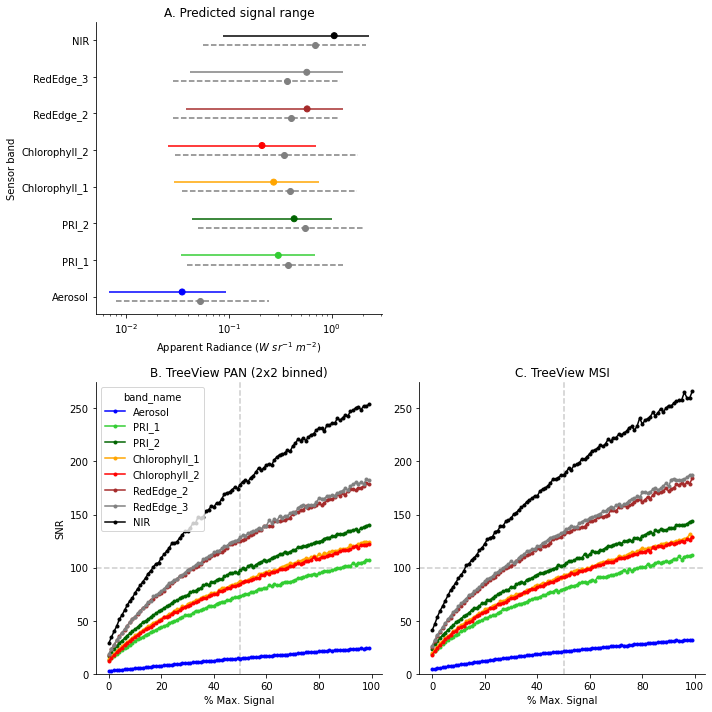

In [12]:
# calculate the 95% range of radiance values in each hi res waveband
per_channel_vegetation = to_quantiles(radiance.where(veg_mask))

# Run simulation for long column MSI and PAN (most sensitive)
tv3_32 = generate_treeview_snr_curves(sensor_configs['TreeView_3_MSI_32'],
                                      per_channel_vegetation)

tv3_64 = generate_treeview_snr_curves(sensor_configs['TreeView_3_PAN_64'],
                                      per_channel_vegetation,
                                      n_repeats=40000,
                                      n_bins=4)

# Plot Results
f, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flat
# Generate grey grid
for _ax in ax[2:]:
    _ax.axhline(100, linestyle='--', c='k', alpha=.2)
    _ax.axvline(50, linestyle='--', c='k', alpha=.2)
    _ax.set_ylim(0, 275)
    _ax.set_prop_cycle(color=cmap2)

ax[1].set_visible(False)

# subplot 2
tv3_64.plot.line(hue='band_name', marker='.', ax=ax[2])
ax[2].set_title('B. TreeView PAN (2x2 binned)')
ax[2].set_ylabel('SNR')
ax[2].set_xlabel('% Max. Signal')

# subplot 3
tv3_32.plot.line(hue='band', marker='.', ax=ax[3],add_legend=False)
ax[3].set_title('C. TreeView MSI')
ax[3].set_xlabel('% Max. Signal')

radiance_range_plot(ax=ax[0])
seaborn.despine()
plt.tight_layout()

## 6. Imagery Simulation

In [13]:
# Simulate MSI bands
msi_sensor = TeledyneCMOS(**sensor_configs['TreeView_3_MSI_32'])
msi_sensor_simulation = msi_sensor.fit_transform(radiance)

# Simulate PAN bands
pan_sensor = TeledyneCMOS(**sensor_configs['TreeView_3_PAN_64'])
pan_sensor_simulation = pan_sensor.fit_transform(radiance)

# generate an NDVI vegetation mask (using input reflectance spectrum)
veg_mask_2m = treeview_ndvi.interp(x=msi_sensor_simulation.x, y=msi_sensor_simulation.y) > .2

### Best UK Imaging Scenario

[]

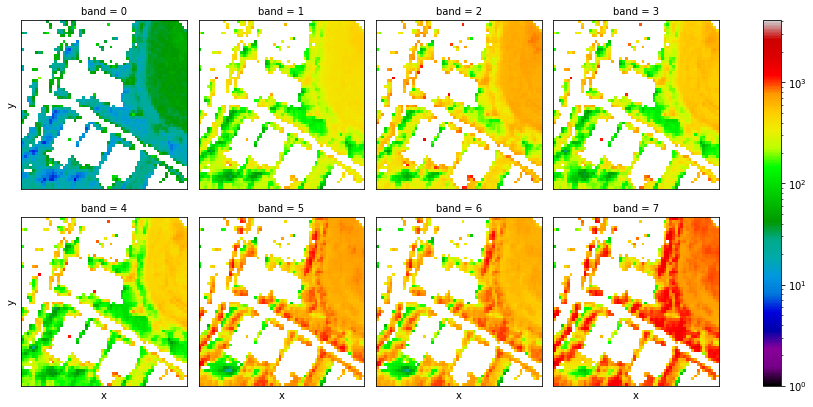

In [14]:
msi_sensor_simulation.where(veg_mask_2m).isel(scenario=6).plot.pcolormesh(col='band',
                                                               col_wrap=4,
                                                               norm=LogNorm(vmin=1, vmax=((2**12)-1)),
                                                               cmap='nipy_spectral')

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])

### Poor UK Imaging Scenario

[]

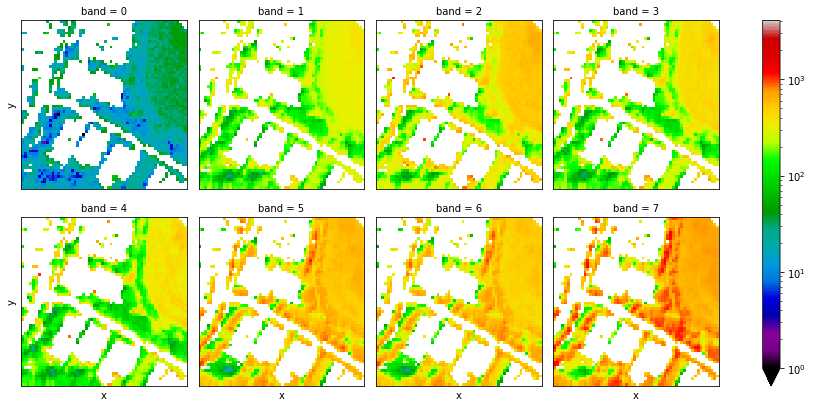

In [15]:
pan_sensor_simulation.where(veg_mask_2m).isel(scenario=6).plot.pcolormesh(col='band',
                                                               col_wrap=4,
                                                               norm=LogNorm(vmin=1, vmax=((2**12)-1)),
                                                               cmap='nipy_spectral')

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])

### Comparative plot

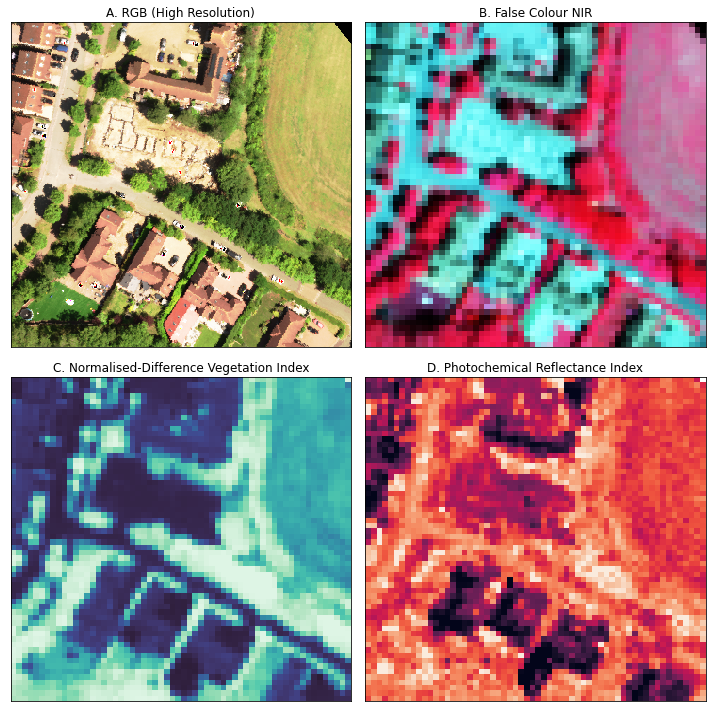

In [16]:
def to_treeview_pri(arr):
    G0 = arr.sel(band=1)
    G1 = arr.sel(band=2)
    return (G0 - G1) / (G0 + G1)

msi_toa_ndvi = to_treeview_ndvi(msi_sensor_simulation)
msi_toa_pri = to_treeview_pri(msi_sensor_simulation)

f, axs = plt.subplots(2,2, figsize=(10,10))
axs=axs.flat
msi_toa_pri.isel(scenario=0).plot(cmap='rocket',
                                             robust=True,
                                             ax=axs[3],
                                             add_colorbar=False)
msi_toa_ndvi.isel(scenario=6).plot(cmap=cmap_mako,
                                              robust=True,
                                              ax=axs[2],
                                              add_colorbar=False)
rgb(msi_sensor_simulation.isel(scenario=6, band=[7, 4, 2]), ax=axs[1])
rgb(surface_reflectance.swap_dims({'wavelength': 'band'}).isel(band=[70, 40, 20]),ax=axs[0])
# rgb(xarray.open_dataset(fpath).Reflectance.isel(band=[70, 40, 20]),ax=axs[0])

for a, name in zip(axs, ['A. RGB (High Resolution)',
                         'B. False Colour NIR',
                         'C. Normalised-Difference Vegetation Index',
                         'D. Photochemical Reflectance Index']):
    a.set_yticks([])
    a.set_xticks([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_title(name)

plt.tight_layout()